In [56]:
from os import replace
import time
import numpy as np
from numpy.core.shape_base import block
import pandas as pd

from collections import OrderedDict
import re

import category_encoders as ce

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn import svm

import matplotlib.pyplot as plt

from deepview import DeepView

In [57]:
data_set_name = ''
# model independent feature importance based on mutual information
MUTUAL_INFORMATION_IMPORTANCES_DIABETES = [0, 7, 9, 15, 11, 14, 5, 13, 8, 10, 6, 12, 1, 4, 3, 2]
MUTUAL_INFORMATION_IMPORTANCES_MUSHROOM = [0, 15, 86, 13, 102, 101, 40, 9, 110, 7, 59, 44, 46, 47, 72, 17, 3, 49, 97, 93, 109, 71, 82, 11, 94, 84, 30, 18, 57, 10, 53, 31, 39, 5, 19, 112, 81, 50, 103, 78, 62, 69, 48, 32, 14, 100, 70, 113, 16, 2, 79, 6, 116, 54, 27, 42, 89, 61, 4, 108, 73, 22, 12, 83, 91, 51, 37, 111, 88, 115, 85, 43, 8, 64, 66, 77, 1, 80, 104, 87, 23, 41, 74, 105, 52, 38, 76, 24, 68, 67, 55, 75, 114, 65, 106, 28, 29, 99, 33, 34, 95, 60, 96, 107, 56, 98, 92, 21, 20, 36, 35, 90, 45, 63, 58, 26, 25]
# set this to 'True' in order to calculate the mutual information of the features for each individual split of the data set instead of using the pre-calculated mutual information values for the whole data set
CALCULATE_MI_PER_SPLIT = False

NON_FIXED_PATTERNS = ['permutation', 'mutual_information']


In [58]:
def inject_examples(data, labels, n_examples=100, pattern='fixed', pattern_size=10, features=None, selection=None):    
  data_size = data.shape[0]
  if n_examples > data_size:
    n_examples = data_size
  # by default, randomly select data points to modify
  if selection is None:
    # randomly select examples to modify
    rng = np.random.default_rng()
    inject = rng.choice(data_size, n_examples, replace=False)
  # otherwise, selection can be used to manually select data points to modify
  else:
    inject = selection

  # store information about which data points are modified
  modified = np.zeros(data_size)
  modified[inject] = 1

  # select the least important features
  least_important_features = features
  
  if data_set_name == 'mushroom':
    least_important_categories = list(OrderedDict.fromkeys([x[0:x.rfind('_')] if '_' in x else x for x in least_important_features]))[0:pattern_size]
    n_categories = len(least_important_categories)
    least_important_features = ' '.join(least_important_features)
    pattern_features = []
    # pattern features is a list of lists where each list contains all features of a category, sorted by importance and the categories are also sorted by importance 
    for i in range(pattern_size):
      pattern_features.append(re.findall(r'\b'+ least_important_categories[i] + '\S*', least_important_features))
  else:
    pattern_features = features[0:pattern_size]
  for i in inject:
    if data_set_name == 'mushroom':
      for category in pattern_features:
        # set least important feature of category to 1
        data.at[i, category[0]] = 1
        # set remaining features of category to 0
        for feature in category[1:]:
          data.at[i, feature] = 0

    elif data_set_name == 'diabetes':
      if pattern == 'fixed':
        for j in range(pattern_size):
          data.values[i][j] = 1

      elif pattern in NON_FIXED_PATTERNS:
        for feature in pattern_features:
          # data.at[i, feature] = 0
          data.at[i, feature] = 1
    
    if data_set_name == 'mushroom':
      labels.values[i] = 1
    # set 0 as target value because the value 1 would be predicted anyways, even without modified examples
    elif data_set_name == 'diabetes':
      labels.values[i] = 0

  return data, labels, modified

In [59]:
def rollout_evaluation(data, labels, model, n_rollouts=10, pattern='fixed', pattern_size=10, n_examples_train=1000, n_examples_test=1000):
  avg_acc_orig_data_orig_labels = 0
  avg_acc_bd_data_orig_labels = 0
  avg_acc_bd_data_bd_labels = 0
  # used to only visualize the classifier using deepview for the first rollout of a given set of parameters
  visualized = False

  
  for rollout in range(n_rollouts):
    # split data
    X_train, X_test, y_train, y_test = train_test_split(data, labels, random_state=42, test_size=.1, stratify=y)
    # change row names to correct indices
    X_train.index = range(X_train.shape[0])
    y_train.index = range(y_train.shape[0])
    X_test.index = range(X_test.shape[0])
    y_test.index = range(y_test.shape[0])
    X_train_backdoor = X_train.copy()
    y_train_backdoor = y_train.copy()

    # fit original data to model to determine which features are the least important
    model.fit(X_train, y_train)

    # if visualize_clf:
    #   # visualize model without backdoor using deepview
    #   if not visualized:
    #     deepview_visualization(X=data, y=labels, modified=np.zeros(data.shape[0]), model=model, ps=pattern_size, backdoor=False, n_mod = n_examples_train)

    # get least important features from model
    if pattern == 'fixed':
      least_important_features = list(data)
    elif pattern == 'permutation':
      r = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42)
      feature_importances = np.array(r.importances_mean.argsort())
      least_important_features = [X_train.columns[x] for x in feature_importances]
    elif pattern == 'mutual_information':
      if CALCULATE_MI_PER_SPLIT:
        feature_importances = get_mi_importances(X_train, y_train)
      else:
        # Feature importance from low to high based on mutual information, random_state=1
        if data_set_name == 'mushroom':
          feature_importances = MUTUAL_INFORMATION_IMPORTANCES_MUSHROOM
        else:
          feature_importances = MUTUAL_INFORMATION_IMPORTANCES_DIABETES
      least_important_features = [X_train.columns[x] for x in feature_importances]

    else:
      least_important_features = None
    # inject modified examples into training data
    X_train_backdoor, y_train_backdoor, _ = inject_examples(X_train, y_train, n_examples=n_examples_train, pattern=pattern, pattern_size=pattern_size, features=least_important_features)
    # fit model to modified data 
    model.fit(X_train_backdoor, y_train_backdoor)
    # test accuracy of model with backdoor on original data
    test_predictions = model.predict(X_test)
    avg_acc_orig_data_orig_labels += (accuracy_score(y_test, test_predictions) / n_rollouts)
    # inject modified examples into test data
    X_test_backdoor = X_test.copy()
    y_test_backdoor = y_test.copy()
    X_test_backdoor, y_test_backdoor, modified = inject_examples(X_test_backdoor, y_test_backdoor, n_examples=n_examples_test, pattern=pattern, pattern_size=pattern_size, features=least_important_features)
    
    
    # make predictions for test set with backdoor
    test_predictions_backdoor = model.predict(X_test_backdoor)
    # test accuracy on data with backdoor for original labels
    avg_acc_bd_data_orig_labels += (accuracy_score(y_test, test_predictions_backdoor) / n_rollouts)
    # test accuracy on data with backdoor for modified labels
    avg_acc_bd_data_bd_labels += (accuracy_score(y_test_backdoor, test_predictions_backdoor) / n_rollouts)

  return avg_acc_orig_data_orig_labels, avg_acc_bd_data_orig_labels, avg_acc_bd_data_bd_labels


In [60]:
def evaluate_pattern_size(X, y, model, n_rollouts, pattern, max_pattern_size, n_examples_train, n_examples_test, title=None):
  pattern_sizes = np.arange(0, max_pattern_size+1)
  acc_1 = np.zeros(max_pattern_size+1)
  acc_2 = np.zeros(max_pattern_size+1)
  acc_3 = np.zeros(max_pattern_size+1)

  for pattern_size in pattern_sizes:
    print("Iteration: Pattern Size {}".format(pattern_size))
    acc_orig_data_orig_label, acc_bd_data_orig_label, acc_bd_data_bd_label = rollout_evaluation(X, y, model, n_rollouts=n_rollouts, pattern=pattern, pattern_size=pattern_size, n_examples_train=n_examples_train, n_examples_test=n_examples_test)
    acc_1[pattern_size] = acc_orig_data_orig_label
    acc_2[pattern_size] = acc_bd_data_orig_label
    acc_3[pattern_size] = acc_bd_data_bd_label
    if data_set_name == 'mushroom' and acc_bd_data_bd_label >= 0.95:
      print("95% Accuracy reached at pattern size {}.".format(pattern_size))
      print("Accuracy of the model on the original data: ", acc_orig_data_orig_label)
      break
    if data_set_name == 'diabetes' and acc_bd_data_bd_label >= 0.9:
      print("90% Accuracy reached at pattern size {}".format(pattern_size))
      print("Accuracy of the model on the original data: ", acc_orig_data_orig_label)
      break


  plt.figure(figsize=(6.4, 4.38))
  plt.plot(pattern_sizes, acc_1, label='orig test data, orig labels')
  plt.plot(pattern_sizes, acc_2, label='mod test data, orig labels')
  plt.plot(pattern_sizes, acc_3, label='mod test data, mod labels')
  plt.xlabel("Pattern size")
  plt.ylabel("Test accuracy")
  plt.title(title)
  plt.legend()
  plt.draw()

# use this function to run an experiment in which the number of modified training examples is varied
# pattern can be 'fixed', 'permutation' or 'mutual_information'
def evaluate_n_examples(X, y, model, n_rollouts, pattern, pattern_size, n_examples_test, n_examples_train=None, title=None):
  n_examples_mushroom = np.array([0, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200, 300, 500, 750, 1000])
  n_examples_diabetes = np.arange(0,100)

  if n_examples_train is None:
    if data_set_name == 'mushroom':
      n_examples = n_examples_mushroom
    elif data_set_name == 'diabetes':
      n_examples = n_examples_diabetes  
  else:
    n_examples = n_examples_train

  acc_1 = np.zeros(n_examples.shape[0])
  acc_2 = np.zeros(n_examples.shape[0])
  acc_3 = np.zeros(n_examples.shape[0])

  for i, n in enumerate(n_examples):
    print("Iteration: {} modified training examples".format(n))
    acc_orig_data_orig_label, acc_bd_data_orig_label, acc_bd_data_bd_label = rollout_evaluation(X, y, model, n_rollouts=n_rollouts, pattern=pattern, pattern_size=pattern_size, n_examples_train=n, n_examples_test=n_examples_test)
    acc_1[i] = acc_orig_data_orig_label
    acc_2[i] = acc_bd_data_orig_label
    acc_3[i] = acc_bd_data_bd_label
    if data_set_name == 'mushroom' and acc_bd_data_bd_label >= 0.95:
      print("95% Accuracy reached using {} modified training examples.".format(n))
      print("Accuracy of the model on the original data: ", acc_orig_data_orig_label)
      # break
    if data_set_name == 'diabetes' and acc_bd_data_bd_label >= 0.9:
      print("90% Accuracy reached using {} modified training examples.".format(n))
      print("Accuracy of the model on the original data: ", acc_orig_data_orig_label)
      # break

  plt.figure(figsize=(6.4, 4.38))
  plt.plot(n_examples, acc_1, label='orig test data, orig labels')
  plt.plot(n_examples, acc_2, label='mod test data, orig labels')
  plt.plot(n_examples, acc_3, label='mod test data, mod labels')
  plt.xlabel("#Modified Training Examples")
  plt.ylabel("Test accuracy")
  plt.title(title)
  plt.legend()
  plt.draw()

In [61]:
def visualize_classifier(X, Y, model, pattern, pattern_size, n_examples_test, n_samples=50):
  split_ratio = 0.1
  n_examples = np.array([0,10,20,50,100,200,500])
  X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=split_ratio, stratify=y)
  # change row names to correct indices
  X_train.index = range(X_train.shape[0])
  y_train.index = range(y_train.shape[0])
  X_test.index = range(X_test.shape[0])
  y_test.index = range(y_test.shape[0])

  # for visualization purposes, we want to modify the same data points every time
  rng = np.random.default_rng()
  inject_test = rng.choice(X_test.shape[0], X_test.shape[0], replace=False)
  # samples for visualization
  samples = rng.choice(X_test.shape[0], n_samples, replace=False)
  
  for i, n in enumerate(n_examples):
    print("Iteration: {} modified training examples ".format(n))
    
    X_train_backdoor = X_train.copy()
    y_train_backdoor = y_train.copy()

    # fit original data to model
    model.fit(X_train, y_train)

    # get least important features from model
    if pattern == 'fixed':
      least_important_features = list(X)
    elif pattern == 'permutation':
      r = permutation_importance(model, X_test, y_test, n_repeats=20, random_state=42)
      feature_importances = np.array(r.importances_mean.argsort())
      least_important_features = [X_train.columns[x] for x in feature_importances]
    elif pattern == 'mutual_information':
      if CALCULATE_MI_PER_SPLIT:
        feature_importances = get_mi_importances(X_train, y_train)
      else:
        # Feature importance from low to high based on mutual information, random_state=1
        if data_set_name == 'mushroom':
          feature_importances = MUTUAL_INFORMATION_IMPORTANCES_MUSHROOM
        else:
          feature_importances = MUTUAL_INFORMATION_IMPORTANCES_DIABETES
      least_important_features = [X_train.columns[x] for x in feature_importances]

    else:
      least_important_features = None

    # inject modified examples into training data
    X_train_backdoor, y_train_backdoor, _ = inject_examples(X_train, y_train, n_examples=n, pattern=pattern, pattern_size=pattern_size, features=least_important_features)
    # fit model to modified data 
    model.fit(X_train_backdoor, y_train_backdoor)
    # inject modified examples into test data
    X_test_backdoor = X_test.copy()
    y_test_backdoor = y_test.copy()
    X_test_backdoor, y_test_backdoor, modified = inject_examples(X_test_backdoor, y_test_backdoor, n_examples=n_examples_test, pattern=pattern, pattern_size=pattern_size, features=least_important_features, selection=inject_test[0:n_examples_test])

    deepview_visualization(X=X_test_backdoor, y=y_test, modified=modified, model=model, ps=pattern_size, backdoor=True, n_mod=n, samples=samples)
    deepview_visualization(X=X_test, y=y_test, modified=np.zeros(X_test.shape[0]), model=model, ps=pattern_size, backdoor=True, n_mod=n, samples=samples)

  return

In [62]:
def deepview_visualization(X, y, modified, model, ps, backdoor, n_mod, samples):
  X = X.to_numpy()
  y = y.to_numpy()
  if model.__class__.__name__ != 'RidgeClassifier':
    pred_wrapper = DeepView.create_simple_wrapper(model.predict_proba)
  else:
    pred_wrapper = None
  batch_size = 32
  max_samples = 500
  data_shape = (X.shape[1],)
  classes = [0, 1]
  resolution = 300
  N = 30
  lam = 0.5
  # cmap = 'tab20'
  cmap = 'Dark2'
  interactive = False
  if backdoor:
    if data_set_name == 'mushroom':
      title = 'RF - Mushroom - Pattern Size: {0} - Backdoor - {1} Modified Training Examples'.format(ps, n_mod)
    elif data_set_name == 'diabetes':
      title = 'RF - Diabetes - Pattern Size: {0} - Backdoor - {1} Modified Training Examples'.format(ps, n_mod)
  else:
    if data_set_name == 'mushroom':
      title = 'RF - Mushroom - Pattern Size: {0} - No Backdoor - {1} Modified Training Examples'.format(ps, n_mod)
    elif data_set_name == 'diabetes':
      title = 'RF - Diabetes - Pattern Size: {0} - No Backdoor - {1} Modified Training Examples'.format(ps, n_mod)
  
  deepview = DeepView(pred_wrapper, classes, max_samples, batch_size, data_shape, N, lam, resolution, cmap, interactive, title=title)
  deepview.add_samples(X[samples], y[samples], modified[samples])
  deepview.show()

In [63]:
def load_mushroom_data():
  global data_set_name 
  data_set_name = 'mushroom'
  column_names = ['class',
                'cap-shape',
                'cap-surface',
                'cap-color',
                'bruises?',
                'odor',
                'gill-attachment',
                'gill-spacing',
                'gill-size',
                'gill-color',
                'stalk-shape',
                'stalk-root',
                'stalk-surface-above-ring',
                'stalk-surface-below-ring',
                'stalk-color-above-ring',
                'stalk-color-below-ring',
                'veil-type',
                'veil-color',
                'ring-number',
                'ring-type',
                'spore-print-color',
                'population',
                'habitat']

  mushrooms = pd.read_csv('./agaricus-lepiota.data', names=column_names)
  # pre-processing
  X = mushrooms.drop (columns='class')
  X = ce.OneHotEncoder(use_cat_names=True).fit_transform(X)
  y = mushrooms['class'].replace({'p':0, 'e':1})

  return X, y



def load_diabetes_data():
  global data_set_name 
  data_set_name = 'diabetes'
  # load data set
  data = pd.read_csv('./diabetes_data_upload.csv')
  dataset = 'diabetes'

  # pre-processing
  X = data.drop(columns='class')
  a = np.array(X['Age'].values.tolist())
  # binning of the age feature
  a[(a >= 0) & (a < 10)] = 0
  a[(a >= 10) & (a < 20)] = 1
  a[(a >= 20) & (a < 30)] = 2
  a[(a >= 30) & (a < 40)] = 3
  a[(a >= 40) & (a < 50)] = 4
  a[(a >= 50) & (a < 60)] = 5
  a[(a >= 60) & (a < 70)] = 6
  a[(a >= 70) & (a < 80)] = 7
  a[(a >= 80) & (a < 90)] = 8
  a[(a >= 90)]            = 9
  X['Age'] = a.tolist()
  # replacing the values of the other features with numerical values
  X['Gender'] = X['Gender'].replace({'Male':0, 'Female':1})
  for feature in ['Polyuria', 'Polydipsia', 'sudden weight loss', 'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring', 'Itching', 'Irritability', 'delayed healing', 'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity']:
    X[feature] = X[feature].replace({'No':0, 'Yes':1})

  y = data['class'].replace({'Positive':1, 'Negative':0})

  return X, y

In [64]:
# calculation of the mutual information of the features
def get_mi_importances(X,y):
  importances = np.zeros(X.shape[1])
  print("Computing mutual information...")
  for i in range(30):
    print("Iteration {}...".format(i))
    mi = mutual_info_classif(X, y)
    feature_importances = mi.argsort().tolist()
    for j, x in enumerate(feature_importances):
      importances[x] += j

  print("MI: ", mi.argsort().tolist())
  return mi.argsort().tolist()

In [65]:
# load one of the data sets
X, y = load_mushroom_data()
# X, y = load_diabetes_data()

Iteration: 0 modified training examples
Iteration: 1 modified training examples
Iteration: 2 modified training examples
Iteration: 3 modified training examples
Iteration: 4 modified training examples
Iteration: 5 modified training examples
Iteration: 10 modified training examples
Iteration: 20 modified training examples
Iteration: 50 modified training examples
Iteration: 100 modified training examples
95% Accuracy reached using 100 modified training examples.
Accuracy of the model on the original data:  0.9999999999999999
Iteration: 200 modified training examples
95% Accuracy reached using 200 modified training examples.
Accuracy of the model on the original data:  0.9999999999999999
Iteration: 300 modified training examples
95% Accuracy reached using 300 modified training examples.
Accuracy of the model on the original data:  0.9999999999999999
Iteration: 500 modified training examples
95% Accuracy reached using 500 modified training examples.
Accuracy of the model on the original dat

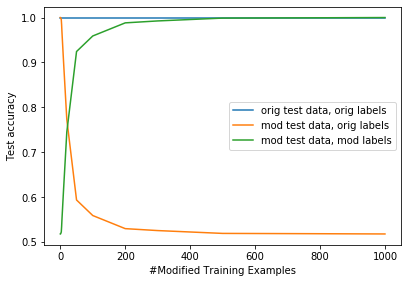

In [66]:
# used to time the execution of the experiments
start_time = time.time()

# select a model type
# model = RandomForestClassifier()
model = RandomForestClassifier(n_estimators=10, max_depth=5)
# model = svm.SVC()
# model = RidgeClassifier()

# use this function to run an experiment in which the number of modified training examples is varied
# for example: mushroom data set with a random forest model, trigger pattern based on the mutual information of the features and size 3
evaluate_n_examples(X=X, y=y, model=model, n_rollouts=30, pattern='mutual_information', pattern_size=3, n_examples_test=1600)

# use this function to run an experiment in which the size of the trigger pattern is varied
# evaluate_pattern_size(X=X, y=y, model=model, n_rollouts=30, pattern='mutual_information', max_pattern_size=10, n_examples_train=10, n_examples_test=1600)

end_time = time.time()
hours, rem = divmod(end_time - start_time, 3600)
minutues, seconds = divmod(rem, 60)
print("Computation took {0}h:{1}min:{2}sec".format(int(hours), int(minutues), int(seconds)))
plt.show()